In [1]:
#general settings
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import pylab
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from astropy import units as u
from astropy import constants as c
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.integrate import odeint
from scipy.interpolate import interp1d
from scipy import optimize
#plt.rcParams['font.family']='FreeSerif'

# settings

In [2]:
sigma=c.sigma_sb.value
R=c.R.value
#gamma=1.4
#Gamma = (gamma - 1)/gamma
Gamma = 0.2
tau_s=1.9
N=2.0 
k=90 #
Ps=1.0 #surface pressure [bar]
Fi=233.0 #W/m2
Fstar=7.0 #W/m2
D = 3.0/2.0 #diffusion coefficient
sigmaSB=5.670367*10**-8 #Stefan-Boltzman constant

# Radiative Convective Adjustment from the surface

## integration of $\hat{F}_+^{(c)}$


In [3]:
def funcFinv(Fup,q):
    if q>0: return 0.0
    val=-(-q)**(N-1)*D*N*tau_s*(Fup - (-q)**(4.0*Gamma))
    return val

In [4]:
p_top=0.00001
q = np.arange(-1.0,-p_top,p_top)
Fup = odeint(funcFinv, 1.0, q)
p=-q

## upward flux of the radiation equilibrium at the RC boundary, $\hat{F}_+^{(r)}$


In [5]:
def Fhatuprad(prc, Frat):
    # Frat is Fstar/Fi
    Dk = D/k
    tpN=tau_s*(prc**N)
    expt = np.exp(-k*tpN)
    deni = 1.0 + D*tpN
    numi = 1.0 + deni
    dens = Frat*(1.0 + Dk + (1.0/Dk - Dk)*expt)
    nums = Frat*(1.0 + Dk + (1.0 - Dk)*expt)
    return (prc**(4.0*Gamma))*(numi + nums)/(deni + dens)

### get the intersection of $F_+^{(c)}$ and $F_+^{(r)}$

In [6]:
dF=Fup[:,0]-Fhatuprad(p,Fstar/Fi)
deltaF = interp1d(p,dF,fill_value="extrapolate")
prc=(optimize.fsolve(deltaF,p_top))[0]
Frc=Fhatuprad(prc,Fstar/Fi)
print(Fhatuprad(prc,Fstar/Fi),prc)

0.661676508314 0.28846730754


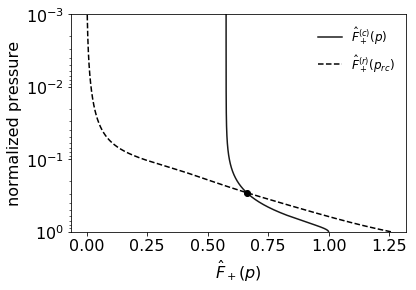

In [7]:
fig = plt.figure()
ax=fig.add_subplot(111)
ax.plot(Fup,p,c="black",alpha=0.9,label="$\hat{F}_+^{(c)} (p)$")
ax.plot(Fhatuprad(p, Fstar/Fi),p,\
        label="$\hat{F}_+^{(r)} (p_{rc})$",c="black",ls="dashed")
plt.gca().invert_yaxis()
plt.yscale("log")
ax.plot(Frc,prc,"o",c="black")
plt.ylabel("normalized pressure",fontsize=16)
plt.tick_params(labelsize=16)
plt.xlabel("$\hat{F}_+(p)$",fontsize=16)
plt.ylim(1,0.001)
ax.legend(loc="upper right",prop={'size':12},frameon=False)
plt.savefig("dryrc.pdf", bbox_inches="tight", pad_inches=0.0)
plt.show()

In [8]:
def Trad(prc, Fi, Fstar):
    # Frat is Fstar/Fi
    Dk = D/k
    tpN=tau_s*(prc**N)
    expt = np.exp(-k*tpN)
    deni = Fi*(1.0 + D*tpN)/2.0
    dens = Fstar*(1.0 + Dk + (1.0/Dk - Dk)*expt)/2.0
    
    return ((deni + dens)/sigmaSB)**0.25

In [9]:
def allTP(plist,prc,Fi,Fstar):
    tlist=np.zeros(len(plist))
    tlist= Trad(prc,Fi,Fstar)*(plist/prc)**Gamma 
    mask=(plist<prc)
    tlist[mask]=Trad(plist[mask],Fi,Fstar)
    return tlist

In [10]:
plist=np.arange(p_top,1.0,p_top)

In [12]:
# US-atmosphere
pus,tus=np.loadtxt("data/tpprof.txt",unpack=True)

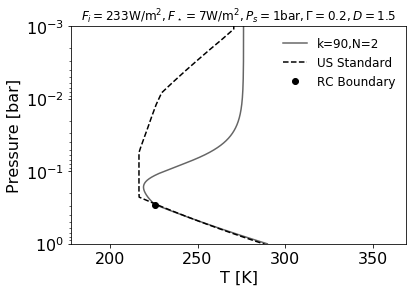

In [13]:
fig = plt.figure()
ax=fig.add_subplot(111)
ax.plot(allTP(plist,prc,Fi,Fstar),plist*Ps,c="black",alpha=0.6,label="k=90,N=2")
ax.plot(tus,pus/1000,c="black",ls="dashed",label="US Standard")
ax.plot(Trad(prc, Fi, Fstar),prc*Ps,"o",c="black",label="RC Boundary")
plt.gca().invert_yaxis()
plt.yscale("log")
plt.ylabel("Pressure [bar]",fontsize=16)
plt.tick_params(labelsize=16)
plt.xlabel("T [K]",fontsize=16)
plt.ylim(1,0.001)
plt.title("$F_i= 233 \mathrm{W/m^2}, F_\star = 7 \mathrm{W/m^2}, \
P_s = 1 \mathrm{bar}, \Gamma=0.2, D=1.5$")
ax.legend(loc="upper right",prop={'size':12},frameon=False)
plt.savefig("dryrcearth.pdf", bbox_inches="tight", pad_inches=0.0)
plt.show()